In [16]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def x_rotations(wires, g):
    for i in range(len(wires)):
        qml.RX(np.pi * g, wires=wires[i])

def ising_zz(wires, thetas):
    for i in range(len(wires)):
        qml.IsingZZ(thetas[i] / 2, wires=wires[i])

def z_rotations(wires, thetas):
    for i in range(len(wires)):
        qml.RZ(thetas[i], wires=wires[i])

def create_init_state(str):
    for i, bit in enumerate(str):
        if bit == 1:
            qml.PauliX(i)
        else:
            qml.Identity(i)

In [25]:
n_wires = 6
dev = qml.device("default.qubit", wires=n_wires)

@qml.qnode(dev)
def time_crystal(start_string, ising_weights, z_weights, g, iters, obs):
    wires = list(np.arange(n_wires))
    create_init_state(start_string)

    def unitary():
        x_rotations(wires, g)

        ising_even_wires = [wires[x:x+2] for x in range(0, len(wires) - 1, 2)]
        ising_odd_wires = [wires[x:x+2] for x in range(1, len(wires) - 1, 2)]

        ising_zz(ising_even_wires, ising_weights[0])
        # Adding identities to make cicuit diagram neater
        qml.Identity(0)
        qml.Identity(wires[-1])
        if (len(ising_weights[1]) != 0):
            ising_zz(ising_odd_wires, ising_weights[1])

        z_rotations(wires, z_weights)
    
    for _ in range(iters):
        unitary()

    return qml.expval(obs)

In [26]:
z_weights = np.random.rand(n_wires) * (2 * np.pi) - np.pi
ising_weights_even = np.random.rand(int(n_wires / 2)) * (np.pi) - (1.5 * np.pi)
ising_weights_odd = np.random.rand(int(n_wires / 2)) * (np.pi) - (1.5 * np.pi)
ising_weights = [ising_weights_even, ising_weights_odd]

start_string = np.random.choice([0, 1], size=n_wires).astype(np.int32)

x = np.arange(50)
gs = [0.50, 0.60, 0.70, 0.80, 0.85, 0.90, 0.95, 0.98, 1.00]

wire_to_measure = int(n_wires / 2)

expvals = [[time_crystal(start_string, ising_weights, z_weights, g, iters, qml.PauliZ(wire_to_measure))[()] for iters in x] for g in gs]


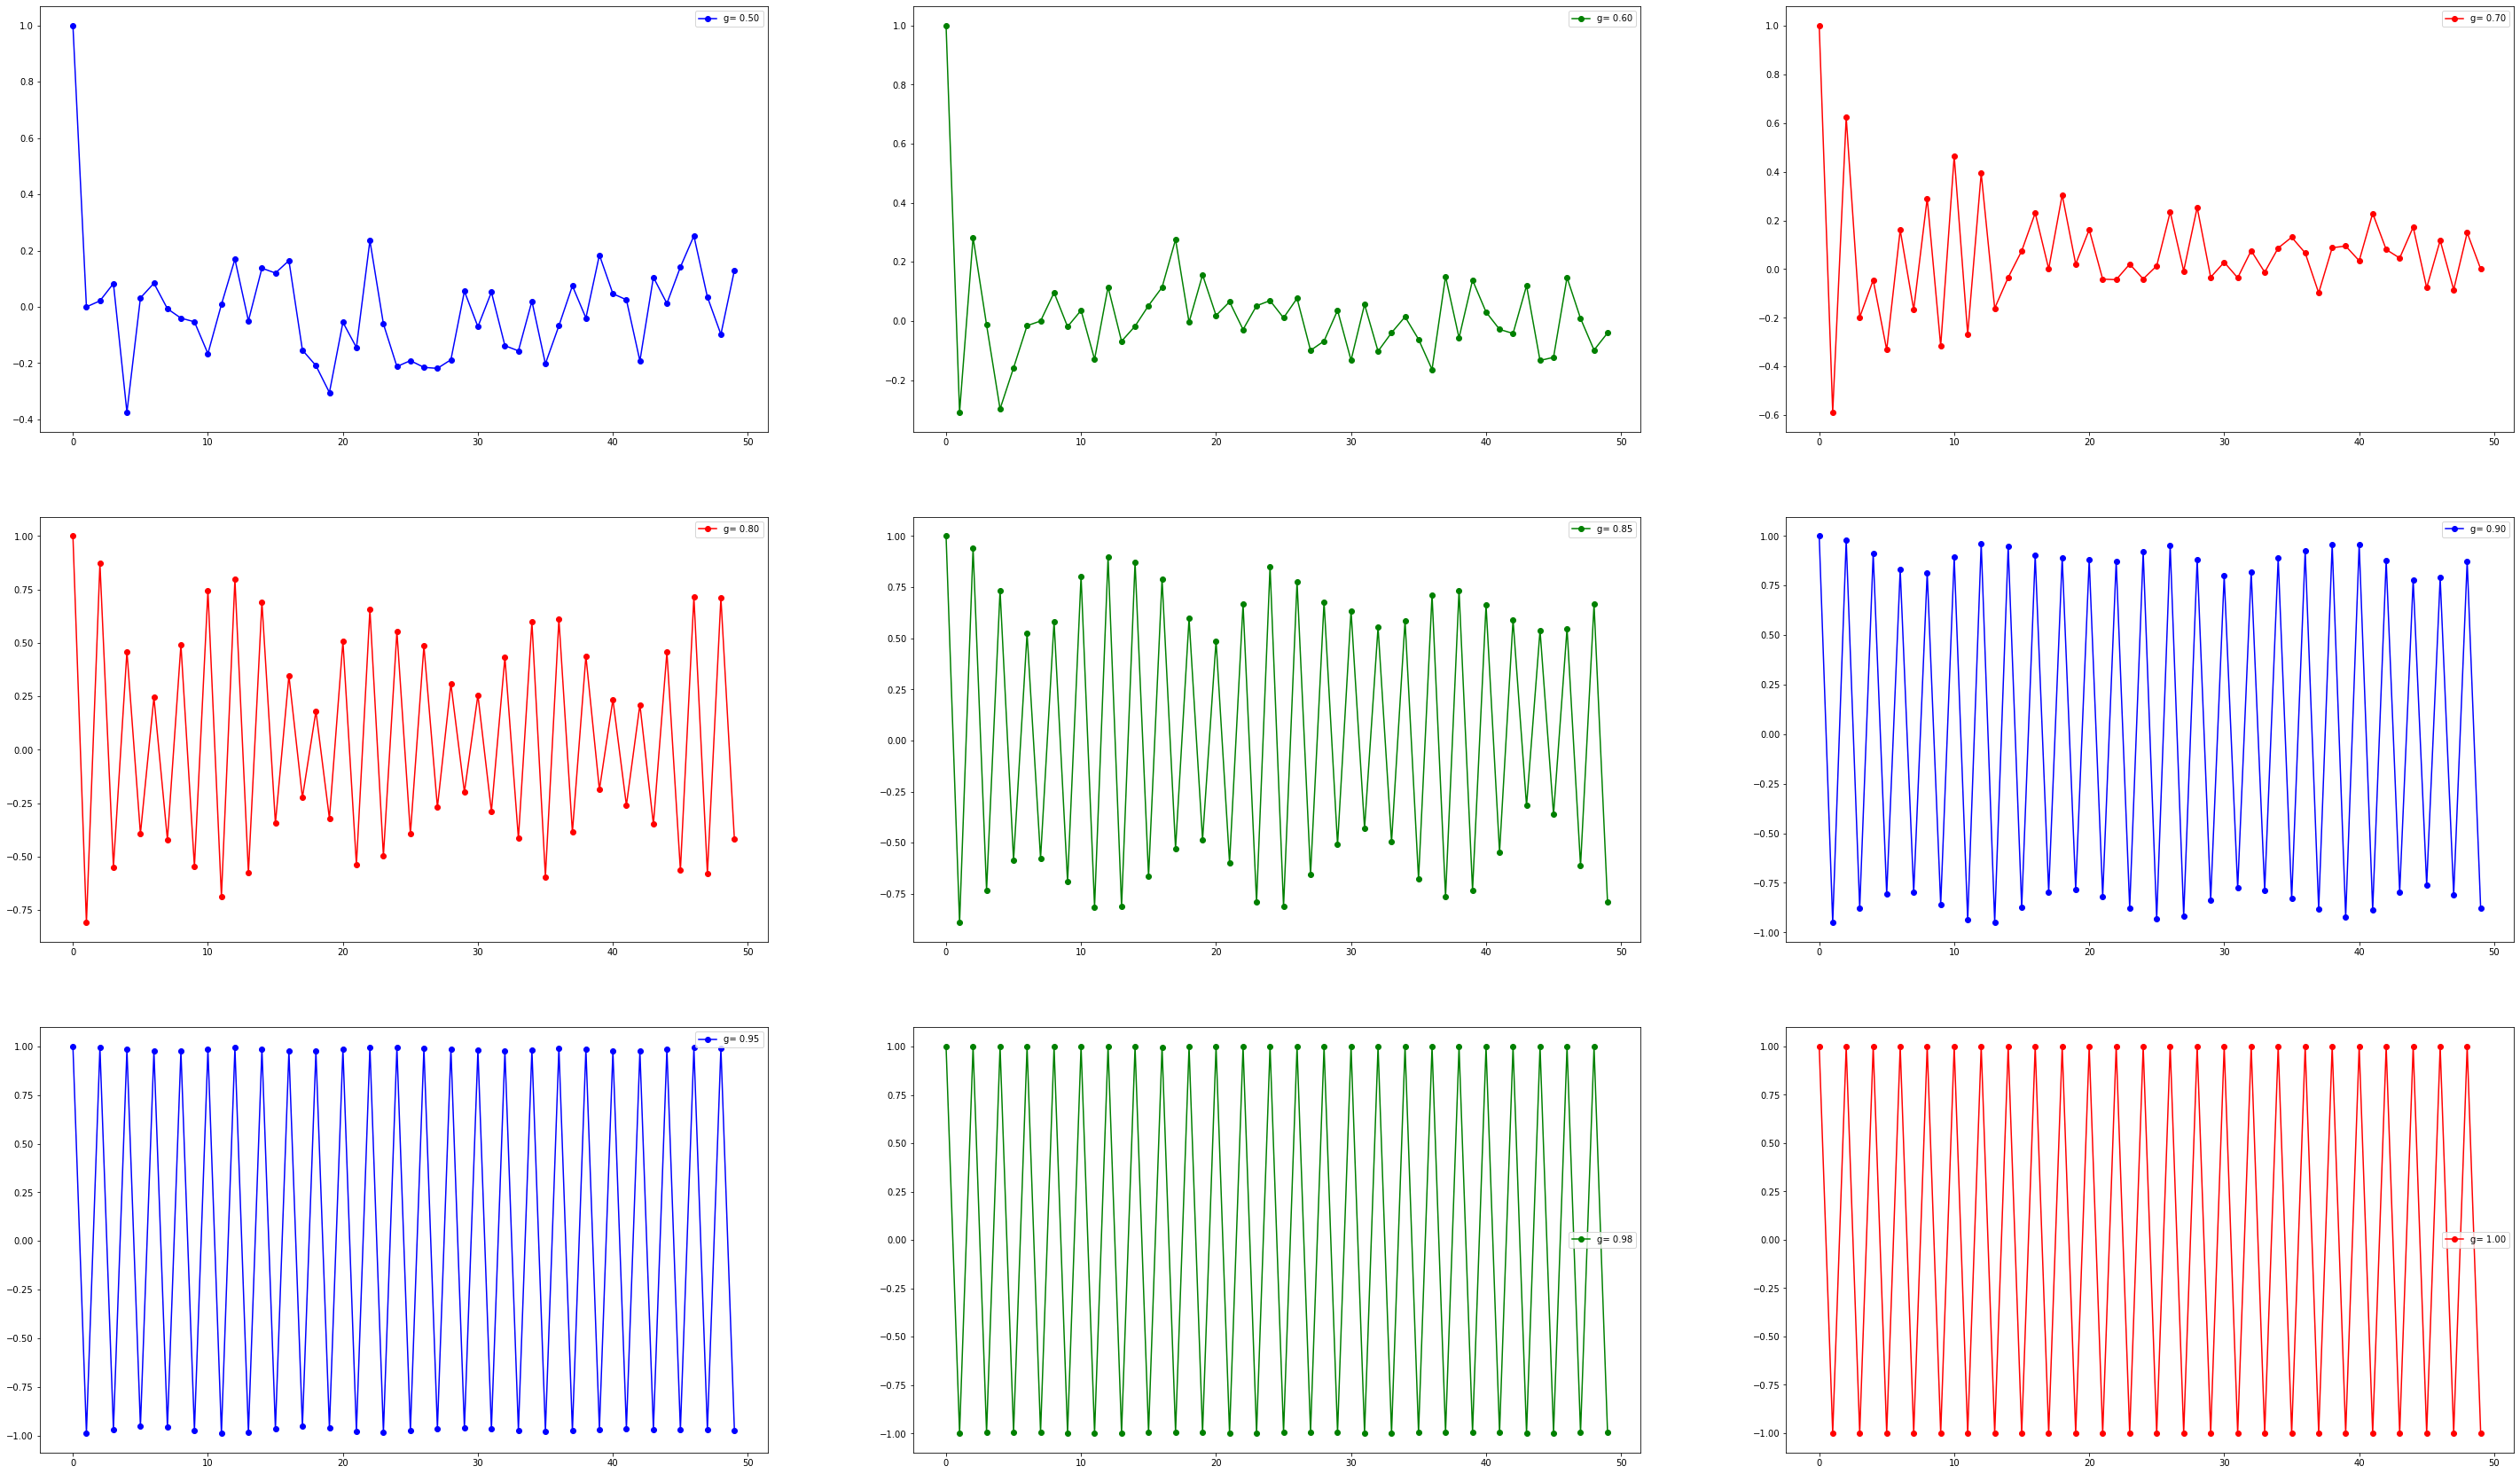

In [27]:
plt.figure(figsize=(50, 30))
colors = ['b', 'g', 'r']
colors = colors + colors[::-1] + colors

for i, expval in enumerate(expvals):
    plt.subplot(3, 3, i + 1)
    plt.plot(x, expval, linestyle='-', marker='o', color=colors[i], label=f"g={gs[i]: .2f}")
    plt.legend()

plt.show()

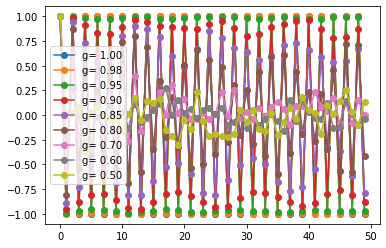

In [28]:
for i, expval in enumerate(expvals[::-1]):
    plt.plot(x, expval, linestyle='-', marker='o', label=f"g={gs[-i-1]: .2f}")

plt.legend()
plt.show()

In [29]:
print(f"Starting string: {start_string}\n\nCircuit:")

drawer = qml.draw(time_crystal, expansion_strategy="device")

print(drawer(start_string, ising_weights, z_weights, 1.0, 1, qml.PauliZ(int(n_wires / 2))))

Starting string: [0 1 0 0 0 0]

Circuit:
0: ──I──RX(3.14)─╭IsingZZ(-1.68)──I───────────────RZ(-0.59)─┤     
1: ──X──RX(3.14)─╰IsingZZ(-1.68)─╭IsingZZ(-1.85)──RZ(-1.46)─┤     
2: ──I──RX(3.14)─╭IsingZZ(-2.24)─╰IsingZZ(-1.85)──RZ(2.86)──┤     
3: ──I──RX(3.14)─╰IsingZZ(-2.24)─╭IsingZZ(-1.48)──RZ(-1.17)─┤  <Z>
4: ──I──RX(3.14)─╭IsingZZ(-1.44)─╰IsingZZ(-1.48)──RZ(2.28)──┤     
5: ──I──RX(3.14)─╰IsingZZ(-1.44)──I───────────────RZ(1.11)──┤     
